### Load data

In [50]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython.display as ipd

from math import sqrt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

import pickle

In [2]:
DATASET_DIR = 'PMEmo/dataset/PMEmo2019'

def load_static_features():
    features_csv = os.path.join(DATASET_DIR, 'features', 'static_features.csv')
    static_features= pd.read_csv(features_csv, index_col=0)
    return static_features

def load_static_features_and_valence():
    static_features = load_static_features()
    valence_csv = os.path.join(DATASET_DIR, 'annotations', 'static_annotations.csv')
    valence = pd.read_csv(valence_csv, index_col=0, usecols=['musicId','Valence(mean)'])
    return static_features.join(valence).dropna()

def load_static_features_and_arousal():
    static_features = load_static_features()
    arousal_csv = os.path.join(DATASET_DIR, 'annotations', 'static_annotations.csv')
    arousal = pd.read_csv(arousal_csv, index_col=0, usecols=['musicId','Arousal(mean)'])
    return static_features.join(arousal).dropna()

def load_audio_dataset(data):
    features = data[data.columns[:-1]].values
    labels = data[data.columns[-1]].values
#     scaler = StandardScaler(copy=False)
#     scaler.fit_transform(features)
    return features, labels

In [3]:
print('In Arousal dimension...')
static_data_a = load_static_features_and_arousal()
static_features_a, static_labels_a = load_audio_dataset(static_data_a)
print('static arousal features shape: {}, static arousal labels shape: {}'.format(static_features_a.shape, static_labels_a.shape))

print('In Valence dimension...')
static_data_v = load_static_features_and_valence()
static_features_v, static_labels_v = load_audio_dataset(static_data_v)
print('static valence features shape: {}, static valence labels shape: {}'.format(static_features_v.shape, static_labels_v.shape))

In Arousal dimension...
static arousal features shape: (767, 6373), static arousal labels shape: (767,)
In Valence dimension...
static valence features shape: (767, 6373), static valence labels shape: (767,)


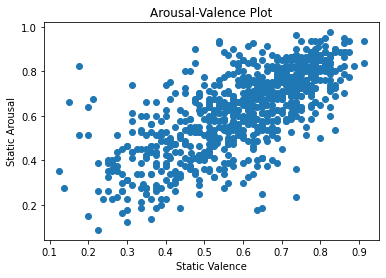

In [4]:
plt.figure()
plt.title('Arousal-Valence Plot')
plt.xlabel('Static Valence')
plt.ylabel('Static Arousal')
plt.scatter(static_labels_v, static_labels_a)

In [2]:
DATASET_DIR = 'PMEmo/dataset/PMEmo2019'
dynamic_features = pd.read_csv(os.path.join(DATASET_DIR, 'features', 'dynamic_features.csv'))
dynamic_annotations = pd.read_csv(os.path.join(DATASET_DIR, 'annotations', 'dynamic_annotations.csv'))
dynamic_dataset = pd.merge(dynamic_features, dynamic_annotations, on=['musicId', 'frameTime'])

### Find the best estimator on static arousal/valence

In [6]:
def rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


regressors = {
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Ridge': Ridge(),
    'kNN': KNeighborsRegressor(),
    'SVRrbf': SVR(kernel='rbf', gamma='scale'),
    'SVRpoly': SVR(kernel='poly', gamma='scale'),
    'SVRlinear': SVR(kernel='linear', gamma='scale'),
    'DT': DecisionTreeRegressor(max_depth=5),
    'RF': RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1)
}

# Standardize features by removing the mean and scaling to unit variance
prefunc = [StandardScaler()]

In [7]:

def cross_val_regression(regressors, features, labels, preprocessfunc):
    columns = list(regressors.keys())
    scores = pd.DataFrame(columns=columns, index=['RMSE'])
    for reg_name, reg in tqdm_notebook(regressors.items(), desc='regressors'):
        scorer = {'rmse': make_scorer(rmse)}
        reg = make_pipeline(*preprocessfunc, reg)
        reg_score = cross_validate(reg, features, labels, scoring=scorer, cv=10, return_train_score=False) 
        scores.loc['RMSE', reg_name] = reg_score['test_rmse'].mean()
#         scores.loc['R', reg_name] = reg_score['test_r'].mean()

    mean_rmse = scores.mean(axis=1)
    std_rmse = scores.std(axis=1)
    
    scores['Mean'] = mean_rmse
    scores['std'] = std_rmse
    return scores

def format_scores(scores):
    def highlight(s):
        is_min = s == min(s)
#         is_max = s == max(s)
#         is_max_or_min = (is_min | is_max)
        return ['background-color: yellow' if v else '' for v in is_min]
    scores = scores.style.apply(highlight, axis=1, subset=pd.IndexSlice[:, :scores.columns[-2]])
    return scores.format('{:.3f}')



In [8]:
print('In Arousal dimension...')
static_scores_a = cross_val_regression(regressors, static_features_a, static_labels_a, prefunc)
ipd.display(format_scores(static_scores_a))

print('In Valence dimension...')
static_scores_v = cross_val_regression(regressors, static_features_v, static_labels_v, prefunc)
ipd.display(format_scores(static_scores_v))

In Arousal dimension...


regressors:   0%|          | 0/9 [00:00<?, ?it/s]

,Lasso,ElasticNet,Ridge,kNN,SVRrbf,SVRpoly,SVRlinear,DT,RF,Mean,std
RMSE,0.184,0.184,0.140,0.136,0.119,0.227,0.110,0.131,0.153,0.154,0.038


In Valence dimension...


regressors:   0%|          | 0/9 [00:00<?, ?it/s]

,Lasso,ElasticNet,Ridge,kNN,SVRrbf,SVRpoly,SVRlinear,DT,RF,Mean,std
RMSE,0.162,0.162,0.163,0.135,0.121,0.225,0.122,0.142,0.141,0.152,0.032


### Train the model on whole static dataset using best estimator (Choose SVR with linear kernel)

In [ ]:
# normalize features
scaler = StandardScaler().fit(static_features_a)
scaled_static_features_a = scaler.transform(static_features_a)

# use normalized features to trian SVR
static_arousal_model = SVR(kernel='linear', gamma='scale')
static_arousal_model.fit(scaled_static_features_a, static_labels_a)
with open(os.path.join('features/emotions/tmp', 'svr_linear_static_arousal.pkl') , 'wb') as fid:
    pickle.dump(static_arousal_model, fid)
print('Trained static arousal model saved at {}'.format(os.path.join('features/emotions/tmp', 'svr_linear_arousal.pkl')))

In [ ]:
# normalize features
scaler = StandardScaler().fit(static_features_v)
scaled_static_features_v = scaler.transform(static_features_v)

# use normalized features to trian SVR
static_valence_model = SVR(kernel='linear', gamma='scale')
static_valence_model.fit(scaled_static_features_v, static_labels_v)
with open(os.path.join('features/emotions/tmp', 'svr_linear_static_valence.pkl') , 'wb') as fid:
    pickle.dump(static_valence_model, fid)
print('Trained static valence model saved at {}'.format(os.path.join('features/emotions/tmp', 'svr_linear_valence.pkl')))

### Find the best estimator on dynamic arousal/valence

In [20]:
def rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))

regressors = {
    # 'Lasso': Lasso(),
    # 'ElasticNet': ElasticNet(),
    # 'Ridge': Ridge(),
    # 'kNN': KNeighborsRegressor(),
    'SVRrbf': SVR(kernel='rbf', gamma='scale'),
    # 'SVRpoly': SVR(kernel='poly', gamma='scale'),
    # 'SVRlinear': SVR(kernel='linear', gamma='scale'),
    # 'DT': DecisionTreeRegressor(max_depth=5),
    # 'RF': RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
#     'MLP': MLPRegressor(hidden_layer_sizes=(200,50), max_iter=2000),
#     'AdaBoost': AdaBoostRegressor(n_estimators=10),
}

In [25]:
def cross_val_regression(regressors, features, labels, preprocessfunc):
    columns = list(regressors.keys())
    scores = pd.DataFrame(columns=columns, index=['RMSE'])

    for reg_name, reg in tqdm_notebook(regressors.items(), desc='regressors'):
        scorer = {'rmse': make_scorer(rmse)}
        reg = make_pipeline(*preprocessfunc, reg)
        reg_score = cross_validate(reg, features, labels, scoring=scorer, cv=10, return_train_score=False) 
        scores.loc['RMSE', reg_name] = reg_score['test_rmse'].mean()
#         scores.loc['R', reg_name] = reg_score['test_r'].mean()
    return scores

def format_scores(scores):
    def highlight(s):
        is_min = s == min(s)
#         is_max = s == max(s)
#         is_max_or_min = (is_min | is_max)
        return ['background-color: yellow' if v else '' for v in is_min]
    scores = scores.style.apply(highlight, axis=1, subset=pd.IndexSlice[:, :scores.columns[-2]])
    return scores.format('{:.3f}')

def regression_results(regressors, trainset, testset, featureNames, labelName, filePrefix, preprocessfunc):
    X_train = trainset[featureNames]
    y_train = trainset[labelName]
    X_test = testset[featureNames]
    y_test = testset[labelName]

    columns = ['musicId', 'y_test'] + list(regressors.keys())
    results = pd.DataFrame(columns=columns)
    results['musicId'] = testset['musicId']
    results['y_test'] = y_test.values
    
    if not os.path.exists('temp_results'):
        os.makedirs('temp_results')
    for reg_name, reg in tqdm_notebook(regressors.items(), desc='regressors'):
        reg = make_pipeline(*preprocessfunc, reg)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        results[reg_name] = y_pred
        results.to_csv(os.path.join('temp_results',f'{filePrefix}_regression_results_{labelName}.csv'))
    
def compute_rmse_across_songs(resultsFile):
    results = pd.read_csv(resultsFile,index_col=0).dropna(axis=1, how='any')
    columns = results.columns[2:]
    scores = pd.DataFrame(columns=columns, index=['rmse_across_segments', 'rmse_across_songs'])
    rmse_across_songs = {}
    testsongs_num = len(results['musicId'].unique())

    for reg_name in columns:
        scores.loc['rmse_across_segments', reg_name] = rmse(results['y_test'], results[reg_name])
        rmse_across_songs[reg_name] = 0

    for i, g in results.groupby('musicId'):
        for reg_name in columns:
            rmse_across_songs[reg_name] += rmse(g['y_test'], g[reg_name])

    for reg_name in columns:
        scores.loc['rmse_across_songs', reg_name] = rmse_across_songs[reg_name]/testsongs_num
    
    mean_rmse = scores.mean(axis=1)
    std_rmse = scores.std(axis=1)
    
    scores['Mean'] = mean_rmse
    scores['std'] = std_rmse
    ipd.display(format_scores(scores))

In [26]:
songs = dynamic_dataset['musicId'].unique()
songs = shuffle(songs, random_state=3)
test_num = round(len(songs)*0.1)
testsongs = songs[:test_num]
print(list(testsongs))
iftestset = dynamic_dataset['musicId'].apply(lambda x: x in testsongs)
testset = dynamic_dataset[iftestset]
trainset = dynamic_dataset[~iftestset]
prefunc = [StandardScaler()]
featureNames = dynamic_dataset.columns[2:262]

regression_results(regressors, trainset, testset, featureNames, 'Arousal(mean)', 'audio', prefunc)
regression_results(regressors, trainset, testset, featureNames, 'Valence(mean)', 'audio', prefunc)

print('In Arousal dimension...')
compute_rmse_across_songs(os.path.join('temp_results','audio_regression_results_Arousal(mean).csv'))
print('In Valence dimension...')
compute_rmse_across_songs(os.path.join('temp_results','audio_regression_results_Valence(mean).csv'))

[63, 490, 34, 743, 104, 177, 79, 894, 14, 668, 683, 151, 504, 516, 355, 98, 97, 579, 892, 837, 152, 169, 388, 391, 561, 850, 985, 958, 572, 514, 625, 791, 517, 507, 501, 1000, 803, 457, 403, 670, 51, 798, 59, 531, 466, 503, 794, 568, 279, 103, 350, 917, 428, 417, 393, 571, 354, 283, 906, 149, 56, 128, 742, 993, 94, 754, 199, 57, 576, 463, 284, 126, 488, 253, 227, 730, 861]


regressors:   0%|          | 0/1 [00:00<?, ?it/s]

regressors:   0%|          | 0/1 [00:00<?, ?it/s]

In Arousal dimension...


,SVRrbf,Mean,std
rmse_across_segments,0.128,0.128,nan
rmse_across_songs,0.107,0.107,nan


In Valence dimension...


,SVRrbf,Mean,std
rmse_across_segments,0.131,0.131,nan
rmse_across_songs,0.109,0.109,nan


### Train the model on whole dynamic dataset using best estimator (Choose SVR with rbf kernel)

In [80]:
dynamic_features_a = dynamic_dataset[dynamic_dataset.columns[2:262]]
dynamic_features_v = dynamic_dataset[dynamic_dataset.columns[2:262]]
dynamic_labels_a = dynamic_dataset['Arousal(mean)']
dynamic_labels_v = dynamic_dataset['Valence(mean)']
prefunc = [StandardScaler()]


In [82]:
# normalize features
scaler = StandardScaler().fit(dynamic_features_a)
scaled_dynamic_features_a = scaler.transform(dynamic_features_a)

# use normalized features to trian SVR
dynamic_arousal_model = SVR(kernel='rbf', gamma='scale')
dynamic_arousal_model.fit(scaled_dynamic_features_a, dynamic_labels_a)
with open(os.path.join('features/emotions/tmp', 'svr_rbf_dynamic_arousal.pkl') , 'wb') as fid:
    pickle.dump(dynamic_arousal_model, fid)
print('Trained dynamic arousal model saved at {}'.format(os.path.join('features/emotions/tmp', 'svr_rbf_dynamic_arousal.pkl')))


Trained dynamic arousal model saved at features/emotions/tmp/svr_rbf_dynamic_arousal.pkl


In [84]:
# normalize features
scaler = StandardScaler().fit(dynamic_features_v)
scaled_dynamic_features_v = scaler.transform(dynamic_features_v)

# use normalized features to trian SVR
dynamic_valence_model = SVR(kernel='rbf', gamma='scale')
dynamic_valence_model.fit(scaled_dynamic_features_v, dynamic_labels_v)
with open(os.path.join('features/emotions/tmp', 'svr_rbf_dynamic_valence.pkl') , 'wb') as fid:
    pickle.dump(dynamic_valence_model, fid)
print('Trained dynamic valence model saved at {}'.format(os.path.join('features/emotions/tmp', 'svr_rbf_dynamic_valence.pkl')))

Trained dynamic valence model saved at features/emotions/tmp/svr_rbf_dynamic_valence.pkl


### Train on balanced data

In [ ]:
def balance_labels(feature_a, feature_v, label_a, label_v, seed):

    ''' evenly select same amount of points in four quadrant'''

    threshold_a, threshold_v = 0.5, 0.5

    quadrant_dict = {'quadrant_1': [], 'quadrant_2': [], 'quadrant_3': [], 'quadrant_4': []}
    # distribute to groups
    for idx in range(len(label_a)):
        if label_a[idx] >= threshold_a and label_v[idx] >= threshold_v:
            quadrant_dict['quadrant_1'].append(idx)
        elif label_a[idx] >= threshold_a and label_v[idx] < threshold_v:
            quadrant_dict['quadrant_2'].append(idx)
        elif label_a[idx] < threshold_a and label_v[idx] < threshold_v:
            quadrant_dict['quadrant_3'].append(idx)
        elif label_a[idx] < threshold_a and label_v[idx] >= threshold_v:
            quadrant_dict['quadrant_4'].append(idx)
        
    balanced_quadrant_size = 1000
    for quadrant, quadrant_idx in quadrant_dict.items():
        if len(quadrant_idx) < balanced_quadrant_size:
            balanced_quadrant_size = len(quadrant_idx)
        print('size of {}: {} '.format(quadrant, len(quadrant_idx)))
    print('size of balanced quadrants: {}'.format(balanced_quadrant_size))

    balanced_idx = []
    for quadrant, quadrant_idx in quadrant_dict.items():
        np.random.seed(seed)
        np.random.shuffle(quadrant_idx)
        balanced_idx.extend(quadrant_idx[:balanced_quadrant_size]) 
    balanced_idx = np.array(balanced_idx)
    return feature_v[balanced_idx], feature_a[balanced_idx], label_v[balanced_idx], label_a[balanced_idx]


In [ ]:
seed = 682
balanced_feature_v, balanced_feature_a, balanced_label_v, balanced_label_a = balance_labels(static_features_a, static_features_v, static_labels_a, static_labels_v, seed)

size of quadrant_1: 505 
size of quadrant_2: 73 
size of quadrant_3: 132 
size of quadrant_4: 57 
size of balanced quadrants: 57


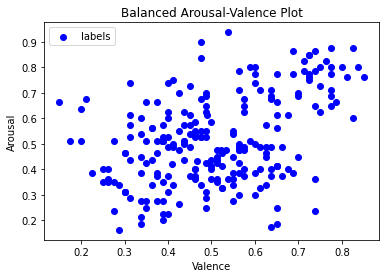

In [ ]:
plt.title('Balanced Arousal-Valence Plot')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.scatter(balanced_label_v, balanced_label_a, c='b', label='labels')
plt.legend(loc='upper left')
plt.show()

### Show result of different fold on balanced data

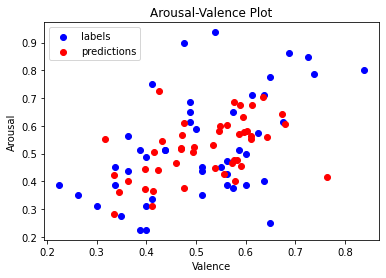

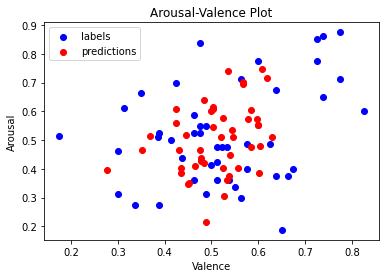

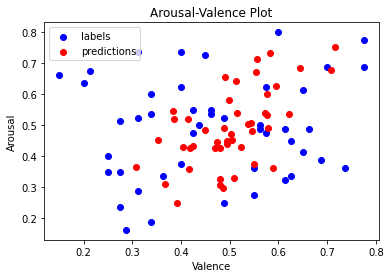

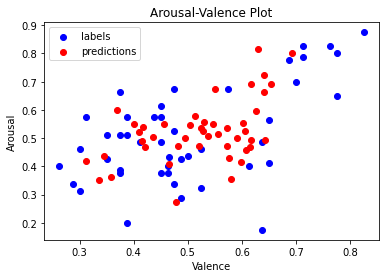

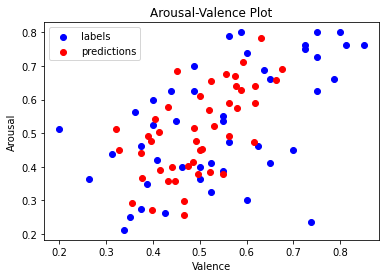

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(balanced_feature_a):
    features_a_train, features_a_test = balanced_feature_a[train_index], balanced_feature_a[test_index]
    labels_a_train, labels_a_test = balanced_label_a[train_index], balanced_label_a[test_index]
    
    scorer = {'rmse': make_scorer(rmse)}
    reg = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
    reg.fit(features_a_train, labels_a_train)
    predictions_a = reg.predict(features_a_test)


    features_v_train, features_v_test = balanced_feature_v[train_index], balanced_feature_v[test_index]
    labels_v_train, labels_v_test = balanced_label_v[train_index], balanced_label_v[test_index]
    
    scorer = {'rmse': make_scorer(rmse)}
    reg = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
    reg.fit(features_v_train, labels_v_train)
    predictions_v = reg.predict(features_v_test)


    plt.figure()
    plt.title('Arousal-Valence Plot')
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.scatter(labels_v_test, labels_a_test, c='b', label='labels')
    plt.scatter(predictions_v, predictions_a, c='r',  label='predictions')
    plt.legend(loc='upper left')
    plt.show()